In [1]:
from simracing import strategize
from simracing.types import Tyre

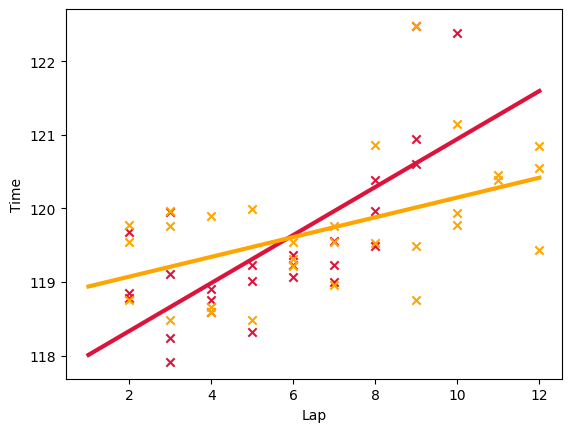

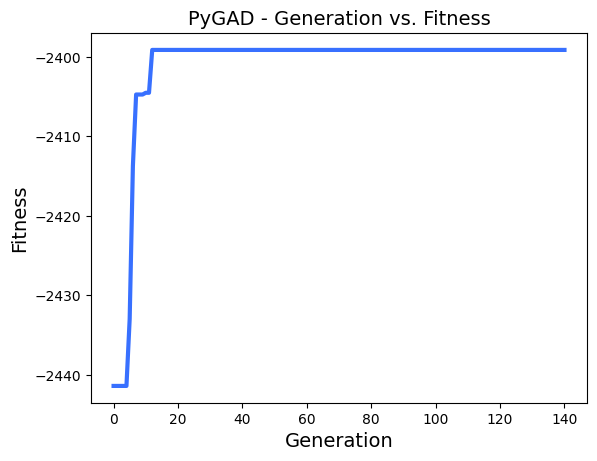

2 [[1, 12], [0, 8]] 2399.1335011841647


In [2]:
# 1. Lago Maggiore; Tx4; Fx3

data = """
Lap	RS	RM
2	118.849	
3	119.106	
4	118.758	
		
2	119.681	119.777
3	119.949	119.961
4		119.898
5	119.228	
6	119.366	119.225
7	119.554	119.768
8	120.389	119.533
9	120.944	119.490
10		119.782
11		120.388
12		120.556
		
2	118.787	119.546
3	118.237	119.758
4	118.592	118.596
5	118.327	119.996
6	119.066	119.544
7	119.007	119.545
8	119.967	120.864
9	122.480	122.476
10	122.380	119.937
11		120.460
12		120.853
		
2		118.762
3	117.915	118.488
4	118.900	118.663
5	119.009	118.490
6	119.237	119.316
7	119.236	118.959
8	119.486	
9	120.605	118.762
10		121.148
11		
12		119.432
"""

model = strategize(
    data,
    available_compounds={Tyre.RS, Tyre.RM},
    required_compounds={Tyre.RS, Tyre.RM},
    lap_count=20,
    max_stint_length=12,
    pit_cost=14,
)

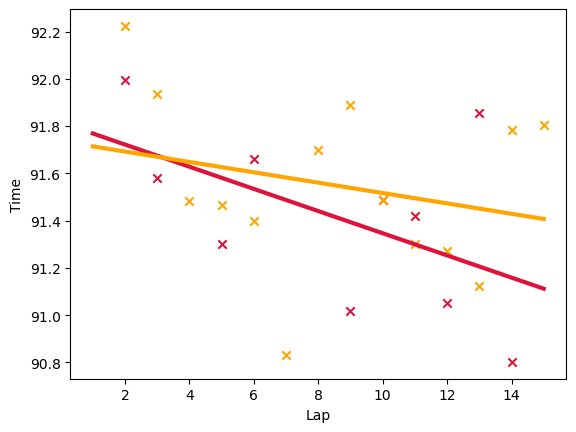

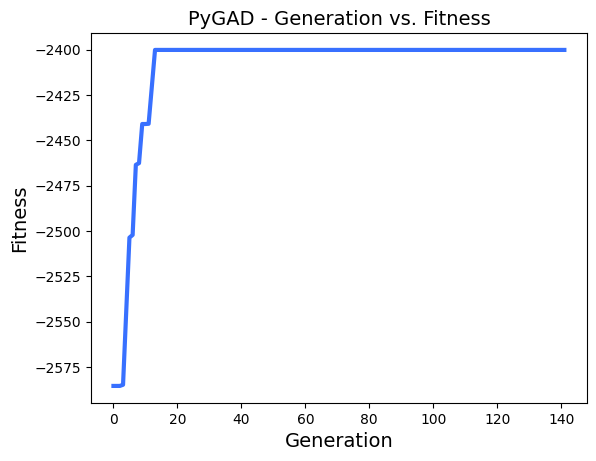

2 [[1, 11], [0, 15]] 2400.1995098901098


In [3]:
# 2. Red Bull Ring; Tx5; Fx3

data = """
Lap	RS	RM
2	91.994	92.224
3	91.580	91.934
4		91.481
5	91.301	91.465
6	91.660	91.398
7		90.831
8		91.697
9	91.018	91.889
10	91.487	91.489
11	91.420	91.302
12	91.051	91.273
13	91.856	91.124
14	90.802	91.783
15		91.805
"""

model = strategize(
    data,
    available_compounds={Tyre.RS, Tyre.RM},
    required_compounds={Tyre.RS, Tyre.RM},
    lap_count=26,
    max_stint_length=15,
    pit_cost=20,  # guesstimate
)

In [5]:
model.evaluate(((Tyre.RS, 11), (Tyre.RM, 15)))

2401.130192967033

In [6]:
model.evaluate(((Tyre.RS, 12), (Tyre.RS, 12),(Tyre.RM, 2)))

2420.8335925274723